In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
# parse_dates[a]: chuyển địh dạng cột a sang dạng datetime
train_df = pd.read_csv("train.csv", parse_dates=["first_active_month"])  
test_df = pd.read_csv("test.csv", parse_dates=["first_active_month"])
print("Number of rows and columns in train set : ",train_df.shape)
print("Number of rows and columns in test set : ",test_df.shape)

Number of rows and columns in train set :  (201917, 6)
Number of rows and columns in test set :  (123623, 5)


In [3]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [4]:
test_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


In [5]:
train_df.describe()

,feature_1,feature_2,feature_3,target
count,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636
std,1.186160,0.751362,0.495683,3.850500
min,1.000000,1.000000,0.000000,-33.219281
25%,2.000000,1.000000,0.000000,-0.883110
50%,3.000000,2.000000,1.000000,-0.023437
75%,4.000000,2.000000,1.000000,0.765453
max,5.000000,3.000000,1.000000,17.965068


In [6]:
test_df.describe()

,feature_1,feature_2,feature_3
count,123623.00000,123623.000000,123623.000000
mean,3.10926,1.741796,0.564377
std,1.18911,0.749195,0.495840
min,1.00000,1.000000,0.000000
25%,2.00000,1.000000,0.000000
50%,3.00000,2.000000,1.000000
75%,4.00000,2.000000,1.000000
max,5.00000,3.000000,1.000000


# Target Column Exploration:


In [7]:
print(range(train_df.shape[0]))


range(0, 201917)


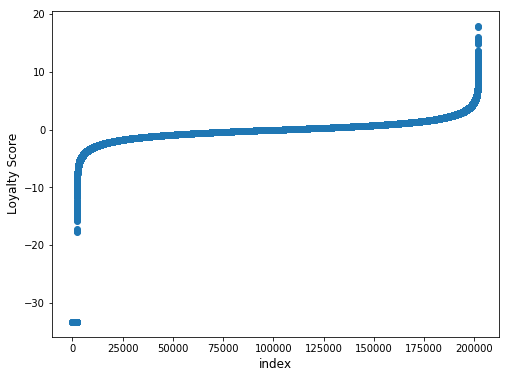

In [8]:
target_col = "target"

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))  #Trục tung là sắp xếp thứ tự của cột target theo thứ tự nhỏ->lớn
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

Tiếp theo ta đếm giá trị trong cột target


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


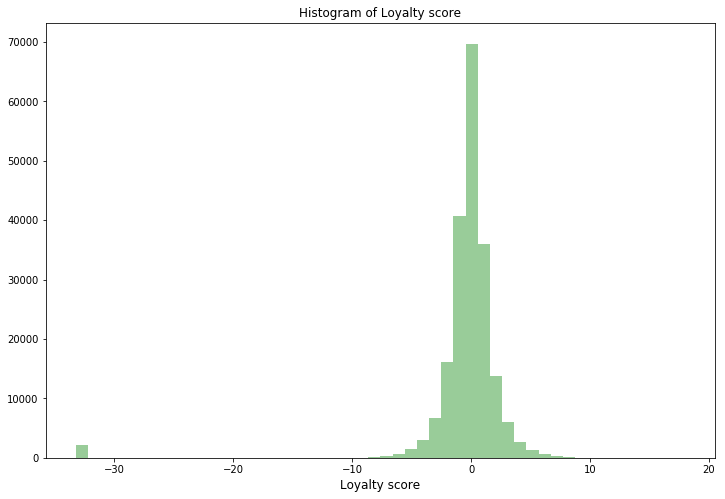

In [9]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="green")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

Có một số target <-30. Ta tập trung phân tích những giá trị này:

In [10]:
(train_df[target_col]<-30).sum()

2207

Loại data này có 2207 dòng chiếm khoảng 1% so với toàn bộ data. Nhưng nó rất khác biệt so với những data còn lại. Có phải là overfit data hay không??



# Feature engineering

In [11]:
#Read file
new_merchant_df = pd.read_csv("new_merchant_transactions.csv") 
hist_df=pd.read_csv("historical_transactions.csv")

In [12]:
new_merchant_df.shape

(1963031, 14)

In [13]:
hist_df.shape

(29112361, 14)

In [14]:
#Tạo hàm chuyển categori trong cột authorized_flag: Y->1, N->0
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

hist_df= binarize(hist_df)
new_merchant_df = binarize(new_merchant_df)

In [15]:
#Dùng hàm dumies vs 2 cột category_2 và category_3
hist_df = pd.get_dummies(hist_df, columns=['category_2', 'category_3'])
new_merchant_df = pd.get_dummies(new_merchant_df, columns=['category_2', 'category_3'])


agg_fun = {'authorized_flag': ['mean']}
auth_mean = hist_df.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)



In [16]:
#Tạo thêm cột purchase_month từ cột purchase_date
hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])
new_merchant_df['purchase_date'] = pd.to_datetime(new_merchant_df['purchase_date'])
hist_df['purchase_month'] = hist_df['purchase_date'].dt.month
new_merchant_df['purchase_month'] = new_merchant_df['purchase_date'].dt.month

In [17]:
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,purchase_month
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,1,0,0,0,0,1,0,0,6
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,1,0,0,0,0,1,0,0,7
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,1,0,0,0,0,1,0,0,8
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,1,0,0,0,0,1,0,0,9
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,1,0,0,0,0,1,0,0,3


In [18]:
#Lập hàm agrregate_transactions để chuẩn bị groupby data theo card_id
def aggregate_transactions(hist_df):
    
    hist_df.loc[:, 'purchase_date'] = pd.DatetimeIndex(hist_df['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    
    }
 #Groupby theo card_id   
    agg_history = hist_df.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (hist_df.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [19]:
#groupby hist_df theo hàm aggregate_transactions đã lập bên trên
hist_df = aggregate_transactions(hist_df)
#đổi tên các cột trong file hist_df bằng cách thêm hist vào đằng trước tất cả các cột
hist_df.columns = ['hist_' + c if c != 'card_id' else c for c in hist_df.columns]
hist_df[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std
0,C_ID_00007093c1,149,28,0.187919,0.000000,0.000000,0.805369,0.0,0.006711,0.000000,0.838926,0.161074,29,18,3,4,13,-76.845041,-0.515739,1.507069,-0.728876,0.298141,192,1.288591,6,1,0.764900,6.375839,12,1,3.303308,-5.852349,0,-12,3.453114
1,C_ID_0001238066,123,2,0.016260,0.772358,0.000000,0.000000,0.0,0.162602,0.000000,0.715447,0.260163,65,29,6,18,17,-72.447201,-0.589002,0.768095,-0.734887,0.190235,198,1.609756,10,-1,1.485637,7.308943,12,1,4.895850,-1.813008,0,-5,1.288980
2,C_ID_0001506ef0,66,0,0.000000,0.030303,0.000000,0.969697,0.0,0.000000,0.984848,0.015152,0.000000,28,19,2,3,12,-34.601879,-0.524271,1.493545,-0.740491,0.472284,1,0.015152,1,0,0.123091,6.803030,12,1,4.524190,-4.833333,0,-13,4.237500
3,C_ID_0001793786,216,2,0.009259,0.050926,0.351852,0.069444,0.0,0.000000,0.976852,0.023148,0.000000,119,48,4,10,24,-36.786013,-0.170306,4.554145,-0.745405,0.836046,5,0.023148,1,0,0.150723,6.671296,10,1,2.306373,-3.328704,0,-9,2.306373
4,C_ID_000183fdda,144,4,0.027778,0.048611,0.006944,0.909722,0.0,0.006944,0.000000,0.715278,0.256944,73,36,7,9,21,-68.837938,-0.478041,2.764788,-0.737892,0.524948,264,1.833333,10,-1,2.118846,6.881944,12,1,4.439959,-2.451389,0,-6,1.895264


In [20]:
#Làm tương tự bước trên với file new_merchant_df
new_merchant_df = aggregate_transactions(new_merchant_df)
new_merchant_df.columns = ['new_' + c if c != 'card_id' else c for c in new_merchant_df.columns]
new_merchant_df[:5]


,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,2,-1.328524,-0.664262,-0.656749,-0.671775,0.010625,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,2.000000,2,2,0.000000
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,9,-14.850055,-0.571156,-0.078318,-0.740897,0.173436,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,1.346154,2,1,0.485165
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,2,-1.447354,-0.723677,-0.715352,-0.732001,0.011773,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,1.000000,1,1,0.000000
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,0.000000,0.000000,31,21,5,7,14,-0.229620,-0.007407,3.129932,-0.737892,0.947223,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,1.322581,2,1,0.475191
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,6,-6.590778,-0.599162,-0.107680,-0.732332,0.182877,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,1.272727,2,1,0.467099


In [21]:
#Merge các bảng lại vs train và test file bằng key card_id
train = pd.merge(train_df, hist_df, on='card_id', how='left')
test = pd.merge(test_df, hist_df, on='card_id', how='left')

train = pd.merge(train, new_merchant_df, on='card_id', how='left')
test = pd.merge(test, new_merchant_df, on='card_id', how='left')

In [22]:
train.to_csv("train_merged.csv")
test.to_csv("test_merged.csv")

# Train model